### Figure 1
- schematic
- spectrogram for NSD and SD
- percentage sleep fraction during first 5h of POST for both SD and NSD sessions


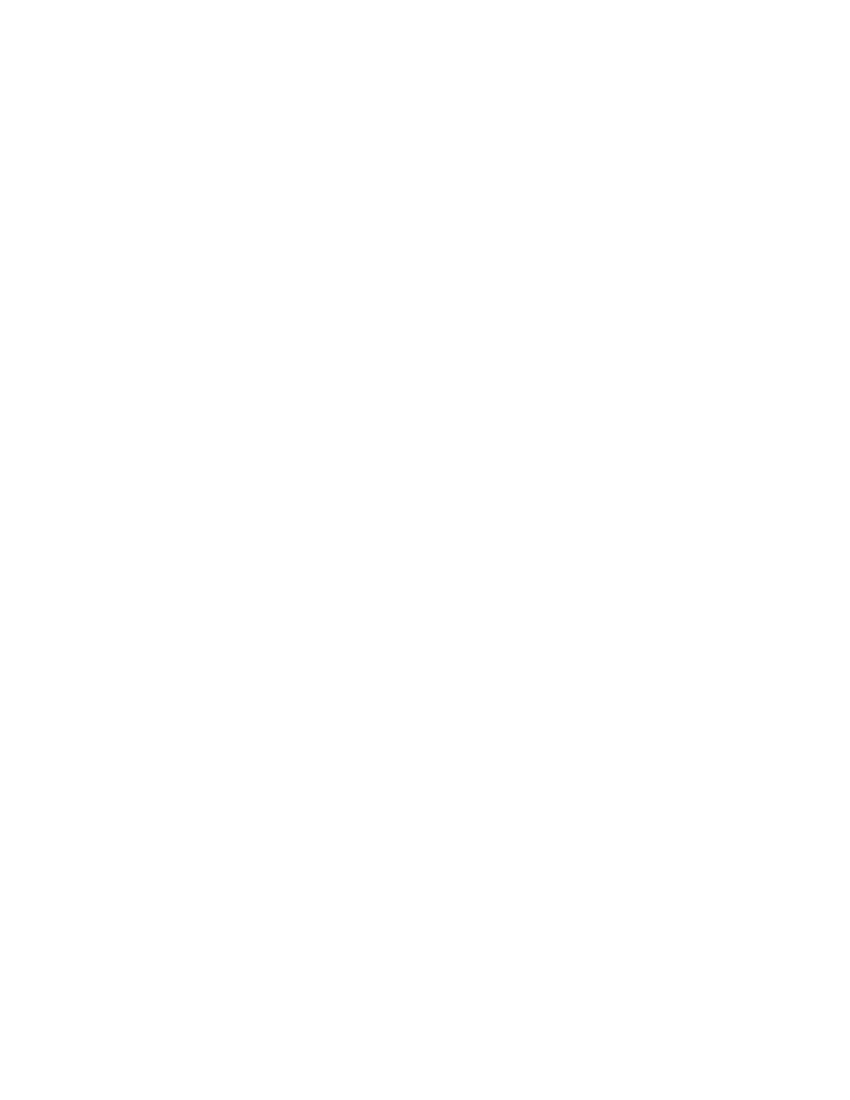

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import subjects
import pandas as pd
import seaborn as sns
from neuropy.plotting import Fig
from scipy import stats
from subjects import light_cycle_span,sns_boxplot_kw, stat_kw

grpdata = subjects.GroupData()
group = ["NSD", "SD"]

#SWA
swa,swa_time,swa_states = grpdata.swa_examples.values()
# brainstates 
states = grpdata.brainstates_proportion

#frate
frate_ratio = grpdata.frate_ratio_nsd_vs_sd
frate = grpdata.frate_zscore
frate = frate[frate.bins> -4]
frate_inter = grpdata.frate_interneuron_around_Zt5
frate_change = grpdata.frate_change_1vs5
frate_change_pre_post = grpdata.frate_change_pre_to_post
colors_frate_change = subjects.colors_sd()

frate_quantiles = grpdata.frate_pre_to_maze_quantiles_in_POST
# frate_quantiles_shuffled= grpdata.frate_pre_to_maze_quantiles_in_POST_shuffled

# plt.clf()
fig = Fig(grid=(6,8),fontsize=8)
filename = subjects.figpath_sd / "figure1_font"

caption = "Figure 1: Changes to firing rate across SD and NSD sessions. \n(A) Slow wave amplitude during POST of example SD and NSD sessions from one animal.\n(B) Porportion time spent in each vigilance state in first 5 h of POST pooled across SD (left) and NSD (right).\n(C) Mean firing rates across across session pooled across animals. Light/dark cycles and sessions epochs are indicated above x-axis.\n(D) Percentage change in firing rate from 1st to 5th hour POST.\n(E) Pentiles firing rate ratio plotted in first 5h of POST. Pentiles were first calculated from percentage increase in firing rate from PRE to MAZE (increasing hue in color). Then mean firing rate of pentiles normalized by each pentile's firing rate in first time bin. Error bars indicate SEM." 


### SWA

In [69]:
from neuropy.plotting import plot_epochs

subfig = fig.fig.add_subfigure(fig.gs[0, :4])
axs = subfig.subplots(4, 1, gridspec_kw=dict(height_ratios=[1, 4, 1, 4]))
# axs[0].plot([1,2,3],[1,2,3])
axs = axs.reshape(2, 2).T
for i in range(2):
    time = swa_time[i]

    plot_epochs(
        swa_states[i],
        ax=axs[0, i],
        labels_order=["nrem", "rem", "quiet", "active"],
        colors=subjects.colors_sleep_old,
    )
    # axs[0,i].set_xlim(time[0],time[-1])
    axs[0,i].set_xlim(0,8*3600)
    axs[0, i].axis("off")

    axs[1, i].plot(time, swa[i],color=subjects.colors_sd(1.4)[i])
    # axs[1, i].step(time, swa[i],color=subjects.colors_sd(1.4)[i])
    # axs[1, i].fill_between(time, swa[i],color=subjects.colors_sd(1.4)[i],alpha=0.5)
    # axs[1, i].fill_between(time, swa[i],ec=subjects.colors_sd(1.5)[i],color=subjects.colors_sd(1.5)[i],alpha=0.6)
    axs[1,i].set_xlim(0,8*3600)
    axs[1,i].set_ylim(0,0.35)
    if i ==0:
        axs[1,i].set_xticks([])
    if i==1:
        xticks = np.arange(8)*3600+ time[0] 
        axs[1, i].set_xticks(xticks, np.arange(8))
        axs[1, i].set_xlabel('Zt time (h)')
        axs[1, i].set_ylabel('SWA (m$V^2$/Hz)')


### zscored firing rate across session

In [70]:
# neuron_colors = ["#f52e14", "#0a8a46"]
neuron_colors = [subjects.colors_sd(1),subjects.colors_sd(1)]
subfig = fig.fig.add_subfigure(fig.gs[1,:5])
axs = subfig.subplots(1,2,sharex=True,sharey=True)
for i, neuron_type in enumerate(["pyr", "inter"]):
    ls = '--' if neuron_type=='inter' else '-'
    neur_color = neuron_colors[i]

    for i1, (grp, grp_color) in enumerate(
        zip(
            group,
            neur_color
        )
    ):
        ax_frate = axs[i1]
        df = frate[(frate["grp"] == grp) & (frate["neuron_type"] == neuron_type)]

        mean_frate = df.groupby("bins").mean()
        x = mean_frate.index
        y = mean_frate.frate.values
        err = df.groupby("bins").sem(ddof=0).frate.values
        ax_frate.fill_between(
            x, y - err, y + err, color=grp_color, alpha=0.3, ec=None, zorder=1
        )
        ax_frate.plot(x, y, grp_color, lw=1, zorder=2,ls=ls)

        # ax_frate.set_title(f"{grp.upper()} sessions", loc="left")
        # baseline=====
        df_pre = frate[frate["bins"] < -0.81]
        df_pre_mean = df_pre.groupby("bins").mean().mean().frate
        ax_frate.axhline(df_pre_mean, ls="--", color="gray")


        light_cycle_span(ax_frate,-4.2,9)
        # epoch_span(ax_frate)

        ax_frate.set_xlabel("ZT time (h)")
        ax_frate.set_xlim([-4, 9])

        ax_frate.set_ylim([-1.2, 1.7])


### Quantify change from PRE(baseline) to POST

In [71]:
from statannotations.Annotator import Annotator

for i, n in enumerate(["pyr", "inter"]):
    df = frate_change_pre_post[frate_change_pre_post["neuron_type"] == n]

    ax = fig.subplot(fig.gs[0, i + 4])
    plot_kw = dict(data=df, x="zt", y="frate_change", hue="grp", hue_order=group, ax=ax)
    sns.boxplot(**plot_kw, **sns_boxplot_kw)
    # sns.stripplot(**plot_kw,dodge=True,s=3)
    # ax.set_yscale('log')
    ax.legend("", frameon=False)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.tick_params("x", labelrotation=45)

    # stats
    orders = df.zt.unique()
    pairs = [((_, "NSD"), (_, "SD")) for _ in orders]
    annotator = Annotator(pairs=pairs, order=orders, **plot_kw)
    annotator.configure(test="Mann-Whitney", **stat_kw)
    annotator.apply_and_annotate()
    annotator.reset_configuration()

    # ax.set_ylim(-120, 600)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2.5-5_NSD vs. 2.5-5_SD: Mann-Whitney-Wilcoxon test two-sided, P_val:2.844e-02 U_stat=5.956e+04
0-2.5_NSD vs. 0-2.5_SD: Mann-Whitney-Wilcoxon test two-sided, P_val:8.353e-01 U_stat=6.519e+04
5-7.5_NSD vs. 5-7.5_SD: Mann-Whitney-Wilcoxon test two-sided, P_val:6.349e-01 U_stat=6.712e+04
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2.5-5_NSD vs. 2.5-5_SD: Mann-Whitney-Wilcoxon test two-sided, P_val:3.383e-02 U_stat=7.840e+02
0-2.5_NSD vs. 0-2.5_SD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.523e-02 U_stat=7.450e+02
5-7.5_NSD vs. 5-7.5_SD: Mann-Whitney-Wilcoxon test two-sided, P_val:5.201e-03 U_stat=1.414e+03


### saving

meta NOT subset; don't know how to subset; dropped
/home/bapung/Documents/Codes/NeuroPy/neuropy/plotting/figure.py:240: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(filename, dpi=dpi, backend="pdf")
meta NOT subset; don't know how to subset; dropped
/home/bapung/miniconda3/envs/data_analysis/lib/python3.10/site-packages/ipympl/backend_nbagg.py:336: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  self.figure.savefig(buf, format='png', dpi='figure')


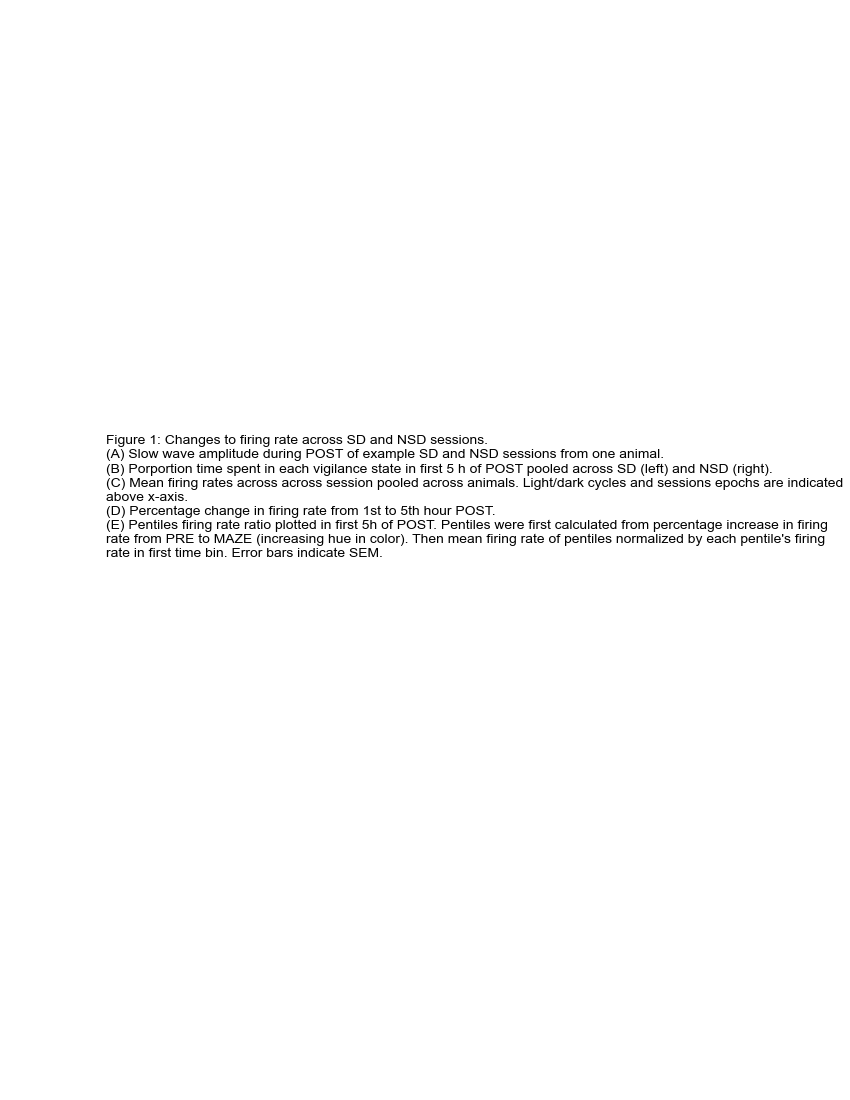

In [72]:
fig.savefig(subjects.figpath_sd/'figure1',caption=caption)